# Simulating a Blackjack game

I will be studying blackjack and writing a blackjack simulator in Python.
The end goal of this project will be to train a nerual network to play blackjack to obtain better results than randomly hitting or sticking.
In addition to random, I will also implement a simulation to mirror the logic I would use if I was to play in the casino. This will be used as a means of comparison.

In [330]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

In [331]:
# Making shuffled decks of cards
def make_decks(num_decks, card_types):
    new_deck = []
    for i in range(num_decks):
        for j in range(4):
            new_deck.extend(card_types)
    random.shuffle(new_deck)
    return new_deck

In [332]:
#function to add a single card when a player/dealer hits
# if ace is dealt, assign correct value 11/1 based on sum of current hand
def add_card(stack, cards):
    new_card = stack.pop()
    if new_card is 'A':
        if sum(cards) + 11 <= 21:
            cards.append(11)
        else: 
            cards.append(1)
    else:
        cards.append(new_card)    
    return cards ,stack


In [333]:
#start of round, player card, dealer card, player card
def init_round(stack):
    p_cards = []
    d_cards = []
    p_cards, stack = add_card(stack, p_cards)
    d_cards,stack = add_card(stack, d_cards)
    p_cards, stack = add_card(stack, p_cards)
    return p_cards, d_cards, stack


This function contains the logic of playing a single game of blackjack. The simulator will call this many times to obtain results over multiple iterations. This function can be called with random, my logic, and the nerual network logic. The correct function will be called.
If player is not bust, the dealer will keep hitting until over 17 or bust. 
Assign the winner based on the rules of blackjack

In [334]:

#if player gets blackjack, wins 1.5 times 

def game(p,d,score,stack, x):
    if sum(p) == 21:
        score['player'] += 1.5
        return score, stack, 21, 1, True 
    if x == 0:
        stack, score, bust, player_card, ps = player_logic(score,stack,p,d)
    elif x == 1:
        stack, score, bust, player_card, ps = player_random(score,stack,p)
    else:
        stack, score, bust, player_card, ps=model_decision(model, score, stack, p,d)
    if bust:
        return score, stack,player_card,0, ps
    while sum(d) < 17:
        d, stack = add_card(stack,d)
        if sum(d) > 21:
            score['player'] += 1
            return score, stack, player_card, 1, ps
    if sum(p)>sum(d):
        score['player'] += 1
        return score, stack, player_card, 1, ps
    elif sum(p) == sum(d):
        score['draw'] += 1
        return score, stack, player_card, 1, ps     
    else:
        score['dealer'] += 1
        return score, stack, player_card, 0, ps
    

This is the logic of how I would play blackjack as if I was in the casino.
Hit if cards sum to less than 12.
Hit if cards are less than 17 and the dealer has a card greater than 6
otherwise stick.

In [335]:
    
def player_logic(score, stack, p,d):
    player_stick = False
    bust = False
    while(not(player_stick)):
        if sum(p) < 12:
            p, stack = add_card(stack,p)
        elif sum(p) < 17 and sum(d) > 6  and sum(d) < 12:
            p, stack = add_card(stack,p)
            if sum(p) > 21:
                score['dealer'] += 1
                bust = True
                p = p[:-1]
                break
        else:
            player_stick = True
    return stack, score, bust, sum(p), player_stick
    

This is the logic of a player using random moves to hit or stick.
50% chance of hitting or sticking until bust.

In [336]:
def player_random(score, stack, p):
        bust = False
        player_stick = False
        action = ['hit','stick']
        while sum(p) < 21:
            ac = ['hit','stick']
            if random.choice(ac) is 'hit':
                p, stack = add_card(stack,p)
                if sum(p) > 21:
                    score['dealer'] += 1
                    bust = True
                    p = p[:-1]
                    break
            else:
                player_stick = True
                break
        return stack,score, bust, sum(p), player_stick
    

The following function simulates the game.
Initilising card types. I have included four 10s in the deck instead of jack, king and queen as we only need numerical value for the game. Ace that has values 11 or 1 will be dealt with using logic.
Playing using 50000 decks of cards is enough to get a clear representation of results and sooths out the randomness.

In [339]:
def simulation(x):
    card_types = ['A',2,3,4,5,6,7,8,9,10,10,10,10]
    num_decs = 50000
    stack = (make_decks(num_decs, card_types))
    score = {'player':0,'dealer':0, 'draw' : 0}
    game_count = 0
    dealer_card = []
    player_card = []
    player_results = []
    player_last_action = []
    while len(stack) > 20:
        game_count+=1
        (p, d, stack) = init_round(stack)
        dealer_card.append(d[0])
        score, stack, pc, pr, pla = game(p,d,score,stack,x)
        player_card.append(pc)
        player_results.append(pr)
        player_last_action.append(pla)
    dealer_win = (score['dealer']/game_count)*100
    draw = (score['draw']/game_count)*100
    player_win_percentage = 100 - (dealer_win + draw) #not taking into account 1.5 for blackjack
    return(player_win_percentage, dealer_win , draw, dealer_card,player_card, player_results,player_last_action)

This code stores the score of who won or draw in addition to extra features required to train the neural network

In [340]:
rplayer, rdealer, rdraw, rdc, rpc, rpr, rpla = simulation(1)
lplayer, ldealer, ldraw, dc, pc, pr, pla = simulation(0)
print(rplayer, rdealer, rdraw)
print(lplayer, ldealer, ldraw)

31.750237778904477 64.34130617410968 3.908456046985852
43.013260452258244 48.63652528602613 8.350214261715626


Dealer always wins, however trying to be tactical is slightly better than playing with random moves


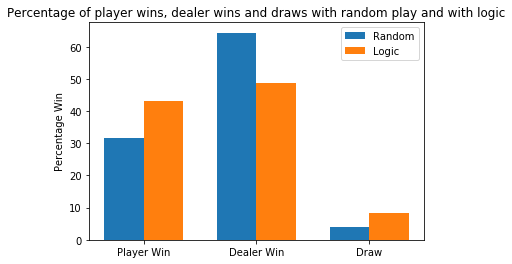

In [341]:
labels = ['Player Win', 'Dealer Win', 'Draw']
rand = [rplayer, rdealer, rdraw]
logic = [lplayer, ldealer, ldraw]
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, rand, width, label='Random')
rects2 = ax.bar(x + width/2, logic, width, label='Logic')

ax.set_ylabel('Percentage Win')
ax.set_title('Percentage of player wins, dealer wins and draws with random play and with logic')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
print("Dealer always wins, however trying to be tactical using the logic specidfied" 
                                          "is better than playing with random moves")

# Building the Neural Net

Using kera library for neural net.
I will only be training the model based on the random simulator, this is to allow the algorithm to detect patterns in the data that a human would not see. 
Setting up dataframe using data stored from running the simulation

In [342]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout

In [343]:
model_df = pd.DataFrame()
model_df['dealer_card'] = rdc
model_df['player_total'] = rpc
model_df['stick?'] = rpla
model_df['win'] = rpr

print(model_df.sample(10))

        dealer_card  player_total  stick?  win
540408           11            21   False    1
540409            6            21   False    1
540410           10            18    True    1
540411            3             6    True    0
540412           10            18    True    0
540413            9            16   False    0
540414            4            10    True    1
540415           11            12    True    1
540416           10            14    True    0
540417            3            13    True    0


Set up our input variables for training the neural network. The variable feature_list is a list with the column names of the features (X variables) that I listed above. The dataframe model_df is where I store all the data from the blackjack simulations that I ran.

creates a sequential type neural net, which is a linear sequence of neural net layers. The lines after this add layers to our model one by one (dense is the simplest layer type and is just a bunch of neurons) — the numbers like 16, 128, etc. specify the number of neurons in each layer.

Activiation function - sigmoid or relu, converts the raw output of the neural network into something interpretable by us. It includes only one neuron because we are predicting between two possible outcomes (two class problem). And second, we use a sigmoid activation because we want our neural net to act like logistic regression and predict whether the correct move is to hit or stay

In [344]:
feature_list = [i for i in model_df.columns if i not in ['win']]
print(feature_list)
train_X = np.array(model_df[feature_list])
train_Y = np.array(model_df['win']).reshape(-1,1)

# Set up a neural net with 5 layers
model = Sequential()
model.add(Dense(16))
model.add(Dense(128))
model.add(Dense(32))
model.add(Dense(8))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='sgd')
model.fit(train_X, train_Y, epochs=20, batch_size=200, verbose=1)

['dealer_card', 'player_total', 'stick?']
Epoch 1/20
540418/540418 [==============================] - 4s 7us/step - loss: 0.5638
Epoch 2/20
540418/540418 [==============================] - 3s 6us/step - loss: 0.5003
Epoch 3/20
540418/540418 [==============================] - 3s 6us/step - loss: 0.4958
Epoch 4/20
540418/540418 [==============================] - 3s 6us/step - loss: 0.4947
Epoch 5/20
540418/540418 [==============================] - 3s 6us/step - loss: 0.4935
Epoch 6/20
540418/540418 [==============================] - 3s 6us/step - loss: 0.4932
Epoch 7/20
540418/540418 [==============================] - 3s 6us/step - loss: 0.4929
Epoch 8/20
540418/540418 [==============================] - 3s 6us/step - loss: 0.4921
Epoch 9/20
540418/540418 [==============================] - 3s 6us/step - loss: 0.4924
Epoch 10/20
540418/540418 [==============================] - 3s 6us/step - loss: 0.4919
Epoch 11/20
540418/540418 [==============================] - 3s 6us/step - loss: 0.4920

In [345]:
pred_Y_train = model.predict(train_X)
actuals = train_Y[:,-1]

In [346]:
print(pred_Y_train)

[[0.887927  ]
 [0.18493345]
 [0.23513266]
 ...
 [0.28111488]
 [0.45344308]
 [0.52859265]]


The ROC Curve tells us how good our model is at trading off between benefit (True Positive Rate) and cost (False Positive Rate) — the greater the area under the curve is, the better the model.

In [ ]:
fpr, tpr, threshold = metrics.roc_curve(actuals, pred_Y_train)
roc_auc = metrics.auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(fpr, tpr, label = ('ROC AUC = %0.3f' % roc_auc))

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
ax.set_xlabel("False Positive Rate",fontsize=16)
ax.set_ylabel("True Positive Rate",fontsize=16)
plt.setp(ax.get_legend().get_texts(), fontsize=16)

The plot below shows the ROC Curve of our blackjack playing neural net.
The neural net seems to be adding a fair bit of value over guessing randomly (the red dashed line). Its area under the curve, or AUC, of 0.82 is significantly higher than the AUC for random guessing (0.50).

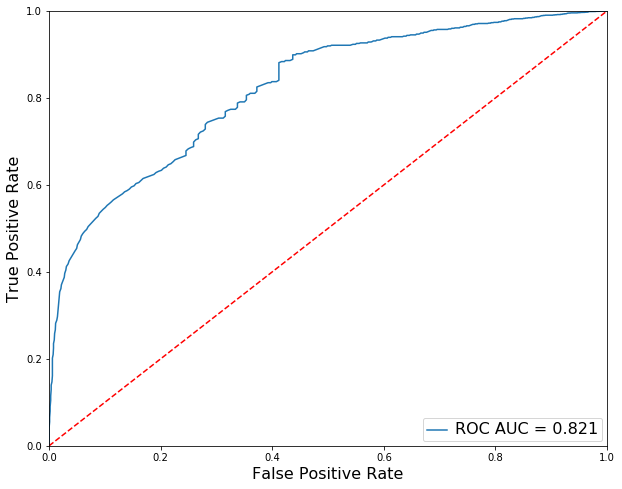

In [347]:
plt.savefig(fname='roc_curve_blackjack', dpi=150)
plt.show()

This function allows the game simulation to use the model to make desicions on whether to hit or stay

In [349]:
def model_decision(model, score, stack, p,d):
    player_stick = False
    bust = False
    while(not(player_stick)):
        input_array = np.array([d[0], sum(p), True]).reshape(1,-1)
        stick = model.predict(input_array)
        input_array = np.array([d[0], sum(p), False]).reshape(1,-1)
        hit = model.predict(input_array)
        if hit > stick:
            p, stack = add_card(stack,p)
            if sum(p) > 21:
                score['dealer'] += 1
                bust = True
                break
        else:
            player_stick = True
    return stack, score, bust, sum(p), player_stick

In [350]:
mplayer, mdealer, mdraw, dc, pc, pr, pla = simulation(3)

In [351]:
print(mplayer, mdealer, mdraw)

39.80862845488535 55.65921667503434 4.532154870080311


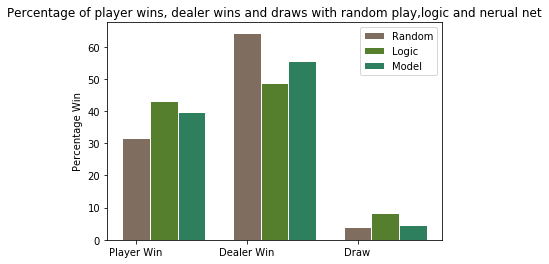

In [356]:
labels = ['Player Win', 'Dealer Win', 'Draw']
rand = [rplayer, rdealer, rdraw]
logic = [lplayer, ldealer, ldraw]
model = [mplayer, mdealer, mdraw]
x = np.arange(len(labels))
barWidth = 0.25
fig, ax = plt.subplots()

r1 = np.arange(len(rand))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]


plt.bar(r1, rand, color='#7f6d5f', width=barWidth, edgecolor='white', label='Random')
plt.bar(r2, logic, color='#557f2d', width=barWidth, edgecolor='white', label='Logic')
plt.bar(r3, model, color='#2d7f5e', width=barWidth, edgecolor='white', label='Model')


ax.set_ylabel('Percentage Win')
ax.set_title('Percentage of player wins, dealer wins and draws with random play,logic and nerual net')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Conclusion

The nerual network beat random by having 8% more wins when playing with 50000 decks of cards.
The nerual network did not beat the logic I would use in the casino but not by much.
The dealer always wins over time.